In [1]:
# Psudoknots prediction

In [14]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

<b>Functions

In [15]:
DNA_obj = Seq('AGTACACTGGT',generic_dna)
print(Seq('AGTACACTGGT',generic_dna).transcribe())
print(DNA_obj.reverse_complement())

AGUACACUGGU
ACCAGTGTACT


<b>Scoring/EnergyScoring

<i>Alignment Score

In [16]:
Bases = ['A','C','G','T']; score = dict(); score['Bases'] = Bases
mismatch = int(input('What\'s the mismatch penalty (a number)?: '));
match = int(input('What\'s the matching score (a number)?: '))
for num,i in enumerate(Bases):
    score[i] = [-mismatch]*4; score[i][num] = match

What's the mismatch penalty (a number)?:  1
What's the matching score (a number)?:  1


In [17]:
Apt = pd.DataFrame(score); Apt.set_index('Bases',inplace = True); Apt

,A,C,G,T
Bases,,,,
A,1,-1,-1,-1
C,-1,1,-1,-1
G,-1,-1,1,-1
T,-1,-1,-1,1


In [94]:
# Sodium Dependence
import numpy as np
def Gibbs_SodiumDependence(StandardGibbs, SodiumConc):
    return StandardGibbs - 0.114*N/2*np.log(SodiumConc)

<i>NN Energy Scores

In [62]:
# Internal Single Mismatch
NNMismatch_raw = pd.read_excel("NNMismatch_Energy.xlsx",header=1); 
df_NN = NNMismatch_raw.set_index('X').drop('Propagation Sequence',axis = 1); df_NN.index.name = 'Base X'; df_NN.columns.name = 'Base Y'
NNMismatch_Energy = pd.concat([df_NN.iloc[:4,:],df_NN.iloc[4:8,:],df_NN.iloc[9:13,:], df_NN.iloc[14:18,:]], keys = ['CX/CY','CX/GY','AX/TY','TX/AY'], names=['Sequence Propagation'])
NNMismatch_Energy

Base Y                           A     C     G     T
Sequence Propagation Base X                         
CX/CY                A       0.170  0.81 -0.25 -1.30
                     C       0.470  0.79 -2.24  0.62
                     G      -0.520 -1.84 -1.11  0.08
                     T      -1.440  0.98 -0.59  0.45
CX/GY                A       0.430  0.75  0.03 -1.45
                     C      -0.790  0.70 -1.84  0.62
                     G       0.110 -2.17 -0.11 -0.47
                     T      -0.128  0.40 -0.32 -0.12
AX/TY                C       0.770  1.33 -1.44  0.64
                     G       0.020 -1.28 -0.13  0.71
                     T      -0.880  0.73  0.07  0.69
                     A       0.690  0.92  0.42 -0.58
TX/AY                G       0.740 -1.45  0.44  0.43
                     T      -1.000  0.75  0.34  0.68

In [89]:
# Watson-Crick Pairing
NNWC_Energy = pd.read_excel("NNWatson-Crick_Energy.xlsx",header=0); NNWC_Energy.iloc[[1,-4,-3,-2,-1],:]

,Propagation Sequence,ΔH (kcal/mol),ΔS (J/Kmol),ΔG@37C(kcal/mol)
1,AT/TA,-7.2,-20.4,-0.88
9,GG/CC,-8.0,-19.9,-1.84
10,Initiation,0.2,-5.7,1.96
11,Terminal AT penalty,2.2,6.9,0.05
12,Symmetry correction,0.0,-1.4,0.43


In [63]:
# Terminal Dangling Ends (none yet)

In [68]:
# Length Dependence of Loop Motif
NNLoopLength_Energy = pd.read_excel("NNLoopLength_Energy.xlsx",header=0); NNLoopLength_Energy.set_index('Loop Size', inplace = True);
NNLoopLength_Energy.head(5)

,Internal loops,Bulge loops,Hairpin loops
Loop Size,,,
1,NaN,4.0,NaN
2,NaN,2.9,NaN
3,3.2,3.1,3.5
4,3.6,3.2,3.5
5,4.0,3.3,3.3


In [53]:
def PairwiseSequenceThermodynamics(seq1, seq2):

CX
CX
AX
TX


In [77]:
# Export Table:  NNEnergy.to_excel("NNEnergy Table.xlsx")

<b>Alignment

In [17]:
class MultiLocalAlignment:
    def __init__(self, ScoringMatrix, indel_penalty):
        self.ScoreMat = ScoringMatrix
        self.indel_penalty = indel_penalty
        #print('Size of Scoring Matrix: ', self.ScoreMat.shape)
        #print('Types : ', list(self.ScoreMat.columns))
    def LCSLocal(self, string1, string2):
        self.string1 = string1; self.string2 = string2
        k1 = len(string1); k2 = len(string2)
        self.node_matrix = np.zeros((k1+1, k2+1)); self.backtrack_matrix = np.zeros((k1+1, k2+1));
        #print('Backtrack Annotations: {Diagnoal:', 0, 'Down:', 1, 'Right:', 2, 'Source:', 3,'}')
        
        self.backtrack_matrix[0,1:] = np.linspace(2, 2, k2); self.backtrack_matrix[1:,0] = np.linspace(1, 1, k1)
        self.node_matrix[0,1:] = np.arange(self.indel_penalty, self.indel_penalty*(k2+1), self.indel_penalty); self.node_matrix[1:,0] = np.arange(self.indel_penalty, self.indel_penalty*(k1+1), self.indel_penalty)
        self.max_score = 0; 
        for i in range(0, k1):           ## Along the Row
            for j in range(0, k2):           ## along the column
                diag_vertice = self.node_matrix[i,j]+self.ScoreMat[string1[i]][string2[j]]
                down_vertice = self.node_matrix[i,j+1] + self.indel_penalty
                right_vertice = self.node_matrix[i+1,j] + self.indel_penalty
                all_vertices = [diag_vertice, down_vertice, right_vertice,  0]
                pointer = np.argmax(all_vertices);  
                self.node_matrix[i+1][j+1] = [diag_vertice,down_vertice,right_vertice, 0][pointer]
                
                #### Find Max Cell + Score (Local only)
                current_nodevalue = self.node_matrix[i+1][j+1]    
                if current_nodevalue >= self.max_score:
                    self.max_score = current_nodevalue
                    self.max_node = (i+1,j+1)
 
                #### Make Backtrack Matrix
                if (i <= k1-1) and (j <= k2-1):
                    self.backtrack_matrix[i+1,j+1] = pointer
        return self.node_matrix, self.backtrack_matrix, self.max_score
    
    def BacktrackLocalAlign(self):
        i,j = self.max_node; self.num_mismatch = 0; self.num_indel = 0
        self.score = 0; self.align1 = ''; self.align2 = ''
        while (i >= 1) or (j >= 1):
            base1 = self.string1[i-1]; base2 = self.string2[j-1];
            if self.backtrack_matrix[i][j] == 0:
                self.align1 = base1 + self.align1; self.align2 = base2 + self.align2
                self.score += self.ScoreMat[base1][base2]
                if base1 != base2:
                    self.num_mismatch += 1
                i -= 1; j -= 1; 
            elif self.backtrack_matrix[i][j] == 1:
                self.align1 = base1 + self.align1; self.align2 = '-' + self.align2
                self.score += self.indel_penalty; self.num_indel += 1
                i -= 1;
            elif self.backtrack_matrix[i][j] == 2:
                self.align1 = '-' + self.align1; self.align2 = base2 + self.align2
                self.score += self.indel_penalty; self.num_indel += 1
                j -= 1
            elif self.backtrack_matrix[i][j] == 3:
                i=0; j=0; 
                self.score += 0
        #print('(Double) Check Score:', self.score ==self.max_score, '| Check Length:', len(self.align1)==len(self.align2))
        return self.score, self.align1, self.align2
    
    def PsuedoAlign(self,string):
        best_score = 0; all_scores = []
        for k in range(len(string)):
            node_matrix, backtrack_matrix, max_score  = LA.LCSLocal(string[k:],rev_string[:-k]); all_scores.append(max_score)
            if max_score > best_score:
                best_score = max_score;
                score, align1, align2 = LA.BacktrackLocalAlign();
                bestLA = LA
        plt.plot(np.arange(0,k+1),all_scores); bestLA.ShowResults()
    
    def ShowResults(self):
        print(self.align1); print(self.align2); print('Score:',self.score); 
        print('Alignment Length:',len(self.align1),'| Mismatch:', self.num_mismatch,'& Indel:',self.num_indel)

In [18]:
indel = int(input('What is the penalty of indel? (Should be negative)'))
if type(indel) == int:
    print('Defined Indel Penalty is ',int(indel))
else:
    raise Exception('Your must input an integer')
try:
    string =  Seq(str(input('Sequence you would like to score for psuedoknots:')),generic_dna)
    rev_string = string.reverse_complement()
except:
    print('Something is wrong')

What is the penalty of indel? (Should be negative) -1


Defined Indel Penalty is  -1


Sequence you would like to score for psuedoknots: ACAGAGAGGTACACACCCAGATGACACACCGAGGTAGA


C-ACC-CAG-ATGACACACCGAGGTAG
CTACCTCGGTGTGTCA-TCTG-GGT-G
Score: 5
Alignment Length: 27 | Mismatch: 5 & Indel: 6


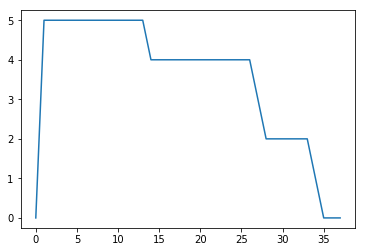

In [19]:
LA = MultiLocalAlignment(Apt,indel);
LA.PsuedoAlign(string)